In [5]:
library(lubridate)
library(data.table)
library(dplyr)
library(Polychrome)
library(ggplot2)
library(grid)
library(gridExtra)
require(invgamma)
require(logitnorm)

# Data preparation and cleaning

In [6]:
datetimediff = function(t){
    t = sapply(strsplit(t, ", "), "[", 2)
    #tt = as.Date(t, format='%d %b %Y %H:%M:%S')
    tt = as.POSIXct(t,format='%d %b %Y %H:%M:%S')
    tt = sapply(tt, function(d) as.numeric(difftime(d , tt[1],units = 'mins'))  )
    return(tt)
}

In [7]:
header = c("RetweetCount", "UserId", "ScreenName", "FollowerCount", "DistanceFromRoot", "Time", "ParentScreenName", "Text")
file_list <- list.files(path="../data/retweet_data/",full.names = T)
dataset = data.frame()
counter = 1
all.data = list()
for (f in file_list){
    d = read.table(f,sep = '\t',col.names = header,header=FALSE, quote="")
    #d$FollowerCount = as.numeric(d$FollowerCount)
    d$TimeDiff = datetimediff(d$Time)
    d$TimeDiff = log(d$TimeDiff+1) # scale to log(x+1)
    d$Time = NULL
    d$Text = NULL
    d$response = NA
    d$rootFollow = NA
    d$rootFollow[1] = head(d$FollowerCount,n=1)
    d$retweets = sapply(d$ScreenName, function(x) d %>% filter(ParentScreenName==x) %>% nrow )
    d$retweets[1] = d$retweets[1] - 1
    d$response[1] = tail(d$RetweetCount,n=1)
    d$TimeRatio = d$TimeDiff/tail(d$TimeDiff,n=1)
    d$RetweetRatio = d$RetweetCount/tail(d$RetweetCount,n=1)
    d$case = counter
    counter = counter + 1
    dataset <- rbindlist(list(dataset, d), use.names = T)
}
dataset %>% mutate(FollowerCount = as.numeric(replace(FollowerCount,FollowerCount=="None",0))) -> dataset
C52 = createPalette(52,  c("#ff0000", "#00ff00", "#0000ff"))
dataset$color = rep(C52, times=c(table(dataset$case)))
#--------------------------------------
head(dataset,30)
dim(dataset)        

RetweetCount,UserId,ScreenName,FollowerCount,DistanceFromRoot,ParentScreenName,TimeDiff,response,rootFollow,retweets,TimeRatio,RetweetRatio,case,color
<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,158426909,Lawrence,87039,0,Lawrence,0.0000000,21,87039,21,0.00000000,0.00000000,1,#FD000D
1,38998962,lancejgosnell,367,1,Lawrence,0.3364722,NA,NA,0,0.05749686,0.04761905,1,#FD000D
2,377745103,EleanorWhitel,444,1,Lawrence,0.4054651,NA,NA,0,0.06928646,0.09523810,1,#FD000D
3,193070651,twitnjackie,42,1,Lawrence,1.1205912,NA,NA,0,0.19148823,0.14285714,1,#FD000D
4,61341105,theblkpanther52,235,1,Lawrence,1.1579289,NA,NA,0,0.19786854,0.19047619,1,#FD000D
5,15594535,JaynePR,898,1,Lawrence,1.2575136,NA,NA,0,0.21488572,0.23809524,1,#FD000D
6,126269760,ScottBaglee,52,1,Lawrence,1.3523928,NA,NA,0,0.23109882,0.28571429,1,#FD000D
7,460577661,fuller_derek,49,1,Lawrence,2.4009210,NA,NA,0,0.41027282,0.33333333,1,#FD000D
8,16730860,dgershwin,415,1,Lawrence,2.4918271,NA,NA,0,0.42580698,0.38095238,1,#FD000D


[1] 12248    14

In [5]:
# Saving model data to disk 
model_input = list(M=dataset$retweets, S = dataset$TimeDiff, f = dataset$FollowerCount, d=dataset$DistanceFromRoot, X=52, N=nrow(dataset), J = na.omit(dataset$response)+1,
                  JCUM = cumsum(na.omit(dataset$response)+1), root_f = as.numeric(na.omit(dataset$rootFollow)))
saveRDS(model_input, '../data/model_input.rds')

# EDA

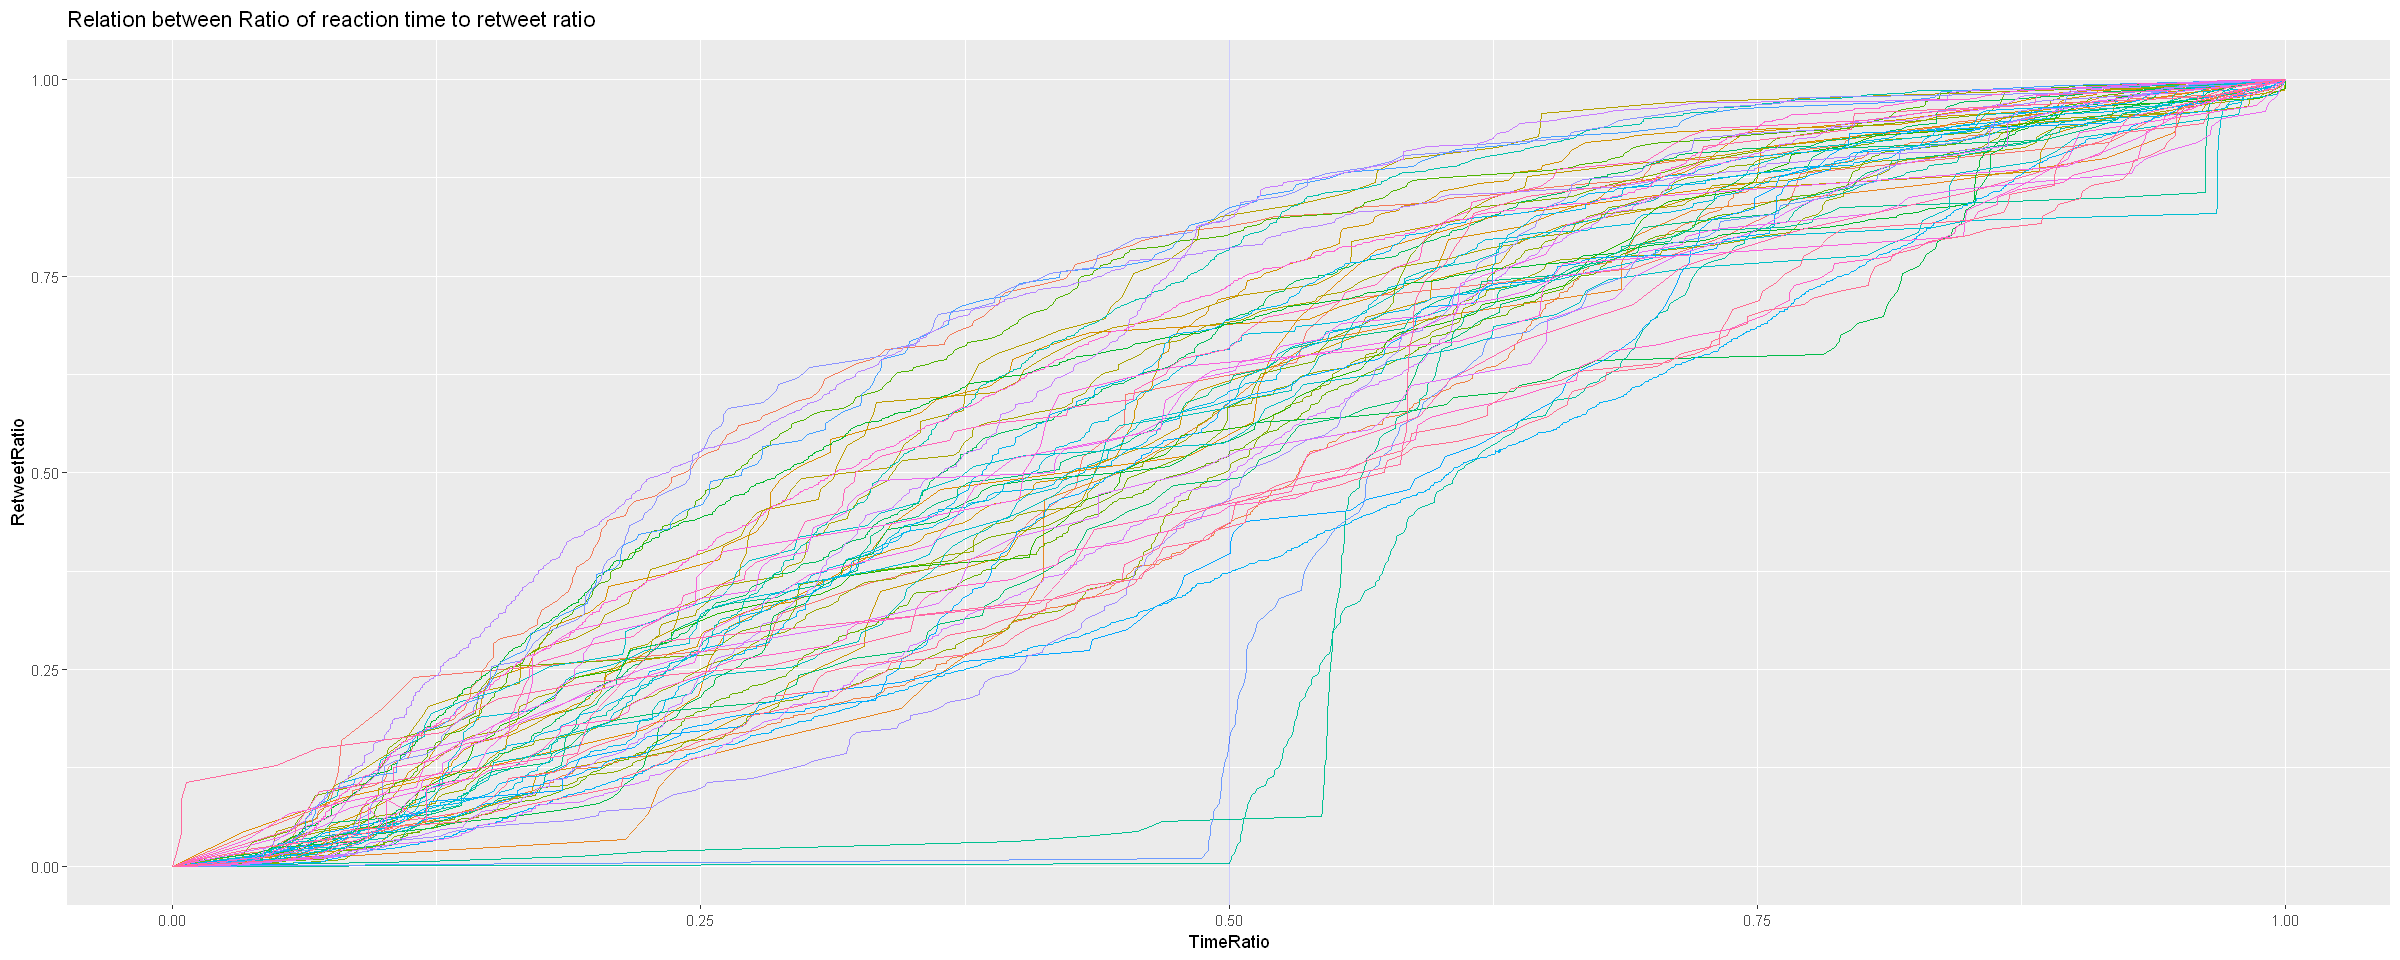

In [9]:
options(repr.plot.width=20, repr.plot.height=8)
dataset %>% group_by(case) %>% 
    ggplot(aes(y= RetweetRatio, x=TimeRatio,col=color)) +
    geom_line() +
    theme(legend.position = "none") +
    geom_vline(xintercept = .5,col='blue',alpha=.2) +
    labs(title="Relation between Ratio of reaction time to retweet ratio")


# 1. Response time

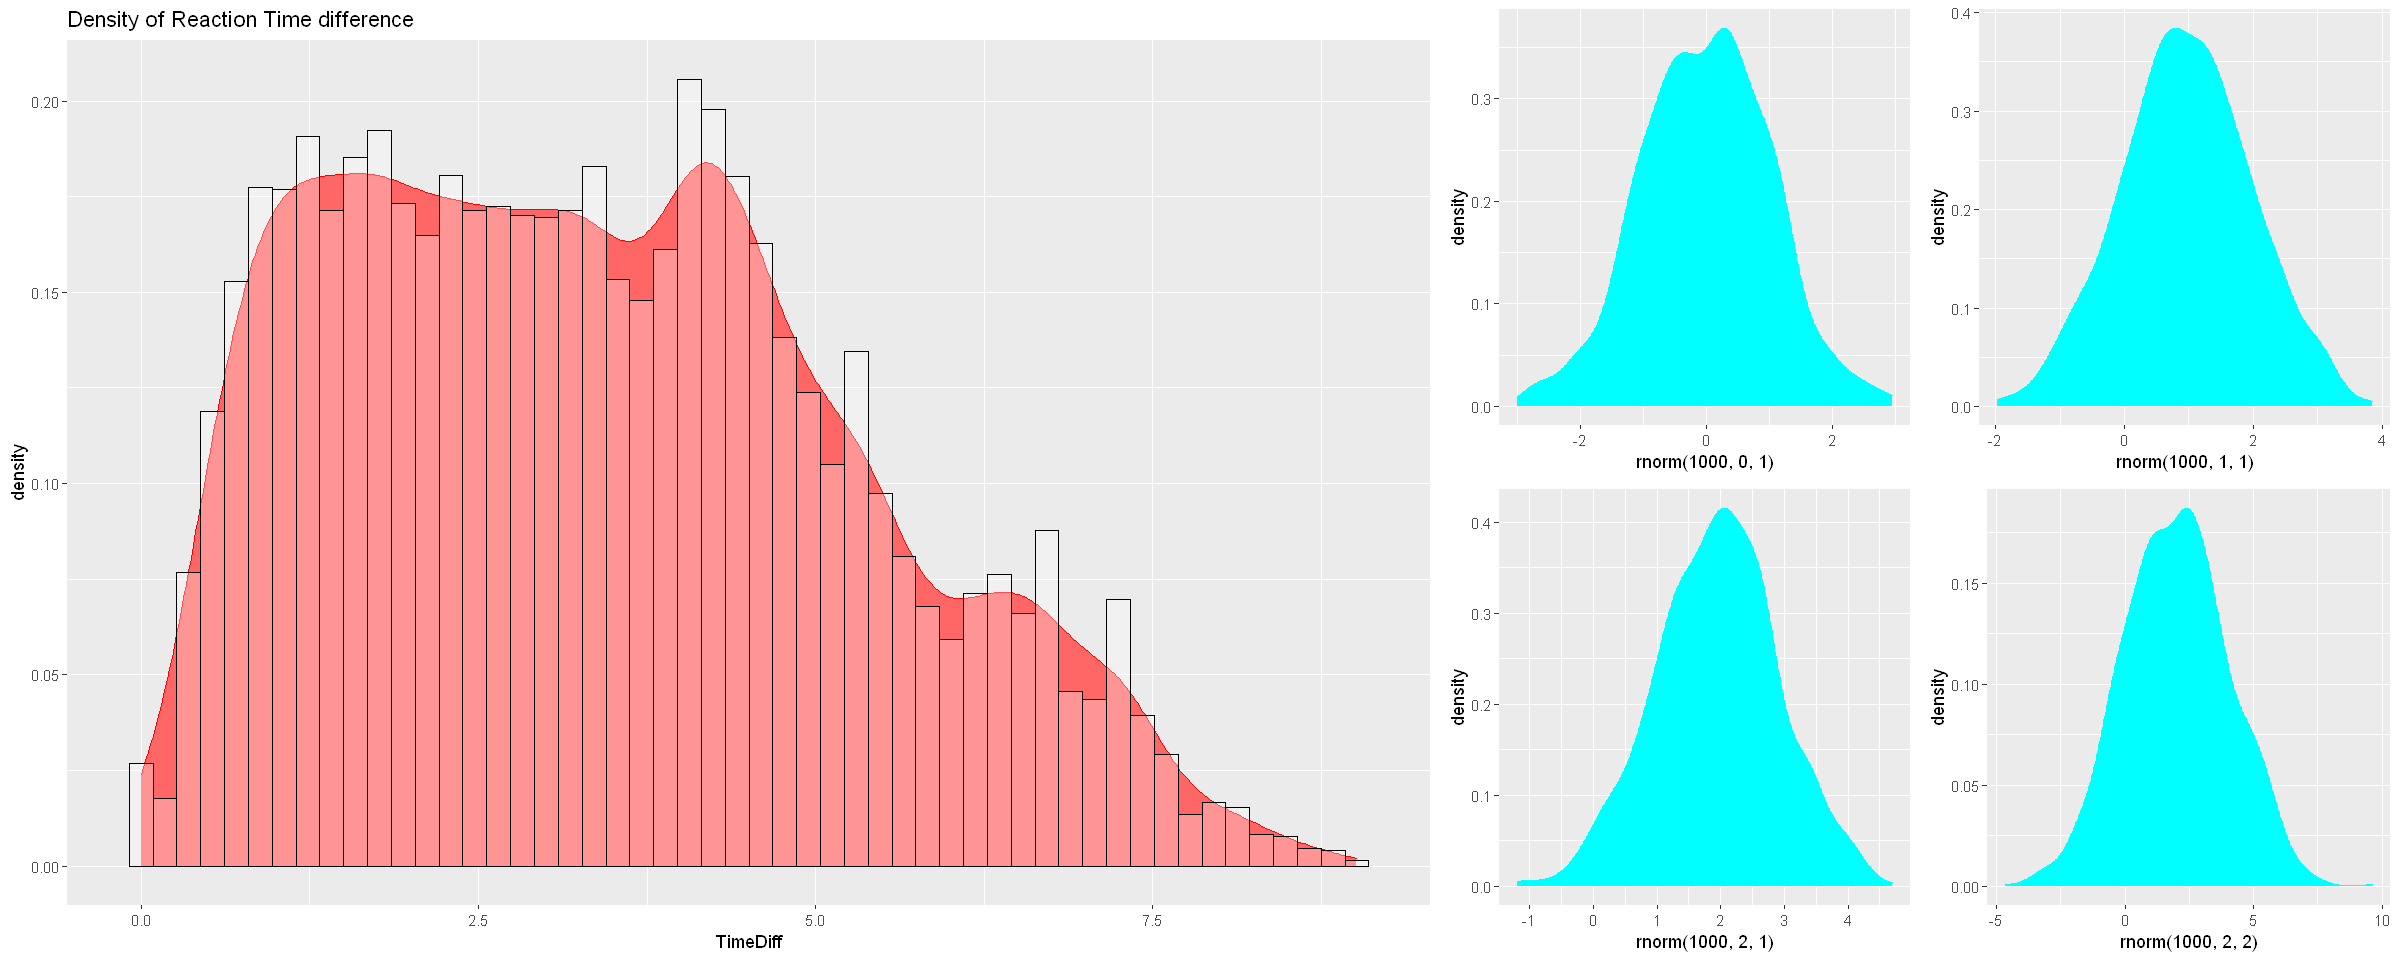

In [6]:
options(repr.plot.width=20, repr.plot.height=8)
q1 <- dataset %>%# filter(RetweetRatio>=.8) %>% group_by(case) %>% filter(row_number()==1) %>% 
    ggplot(aes(x=TimeDiff)) +
    geom_density(color='red',fill="#FF6666") +
    geom_histogram(aes(y=..density..),bins=52,alpha=.3, position="identity",colour="black", fill="white")+ 
    #coord_cartesian(xlim = c(0, 4000)) + 
    labs(title = "Density of Reaction Time difference")

q2 <- ggplot() + geom_density(aes(x=rnorm(1000,0,1)), color='cyan',fill='cyan') 
q3 <- ggplot() + geom_density(aes(x=rnorm(1000,1,1)), color='cyan',fill='cyan') 
q4 <- ggplot() + geom_density(aes(x=rnorm(1000,2,1)), color='cyan',fill='cyan') 
q5 <- ggplot() + geom_density(aes(x=rnorm(1000,2,2)), color='cyan',fill='cyan') 

grid.arrange(q1,q2,q3,q4,q5,
  widths = c(2, 1, 1,1),
  layout_matrix = rbind(c(1, 1, 2,3),
                        c(1, 1, 4,5))
)

# 2. Retweet Count

In [44]:
table(dataset$DistanceFromRoot)


    0     1     2     3 
   52 11882   307     7 

                          Df Sum Sq Mean Sq F value Pr(>F)    
log(FollowerCount + 1)     1  161.2  161.24    1756 <2e-16 ***
DistanceFromRoot           1  148.8  148.76    1620 <2e-16 ***
Residuals              12245 1124.3    0.09                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

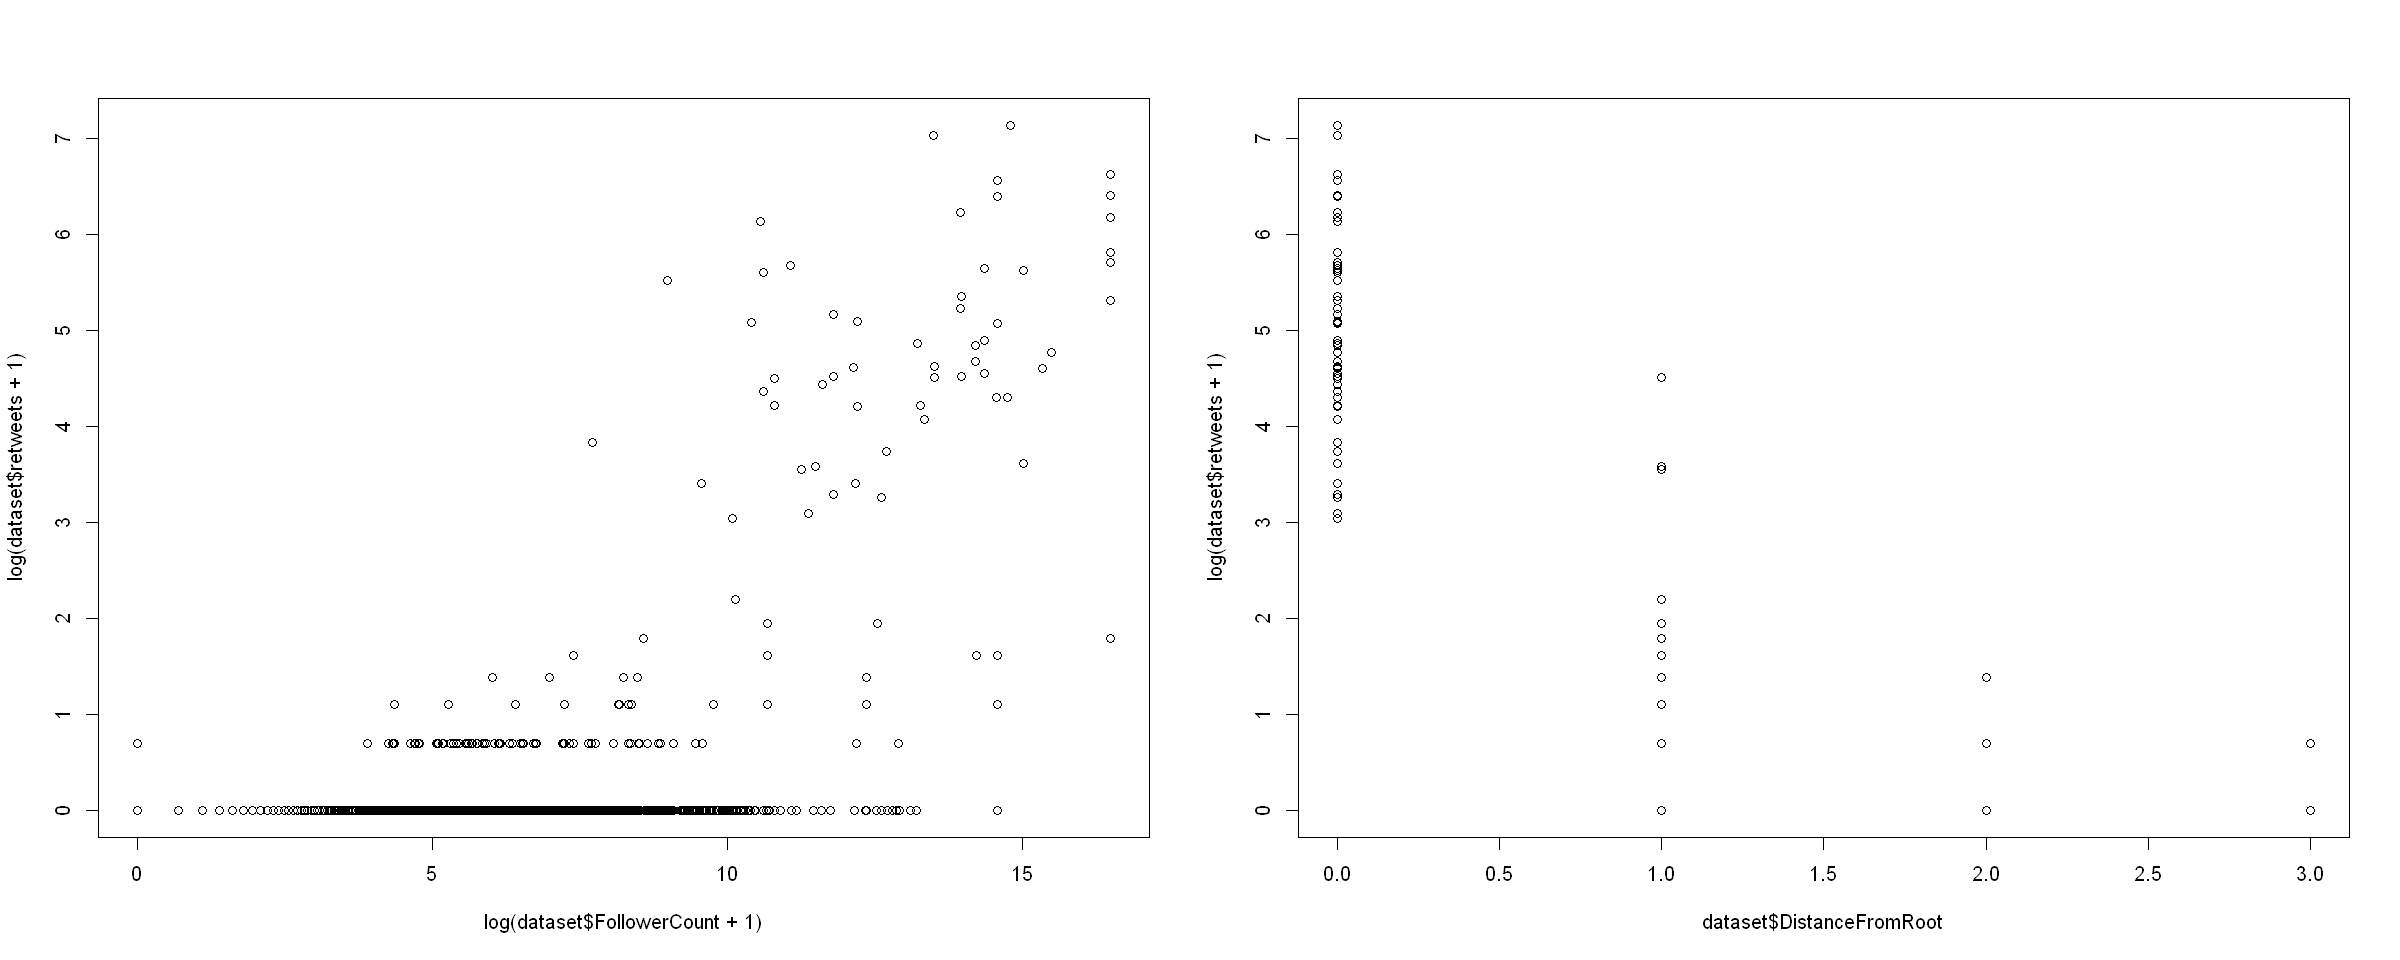

In [96]:
#root.data = filter(dataset, DistanceFromRoot==0)
par(mfrow=c(1,2))
plot(log(dataset$FollowerCount+1), log(dataset$retweets+1))
plot(dataset$DistanceFromRoot, log(dataset$retweets+1))
summary(aov(log(retweets+1) ~ log(FollowerCount+1) + DistanceFromRoot, dataset))

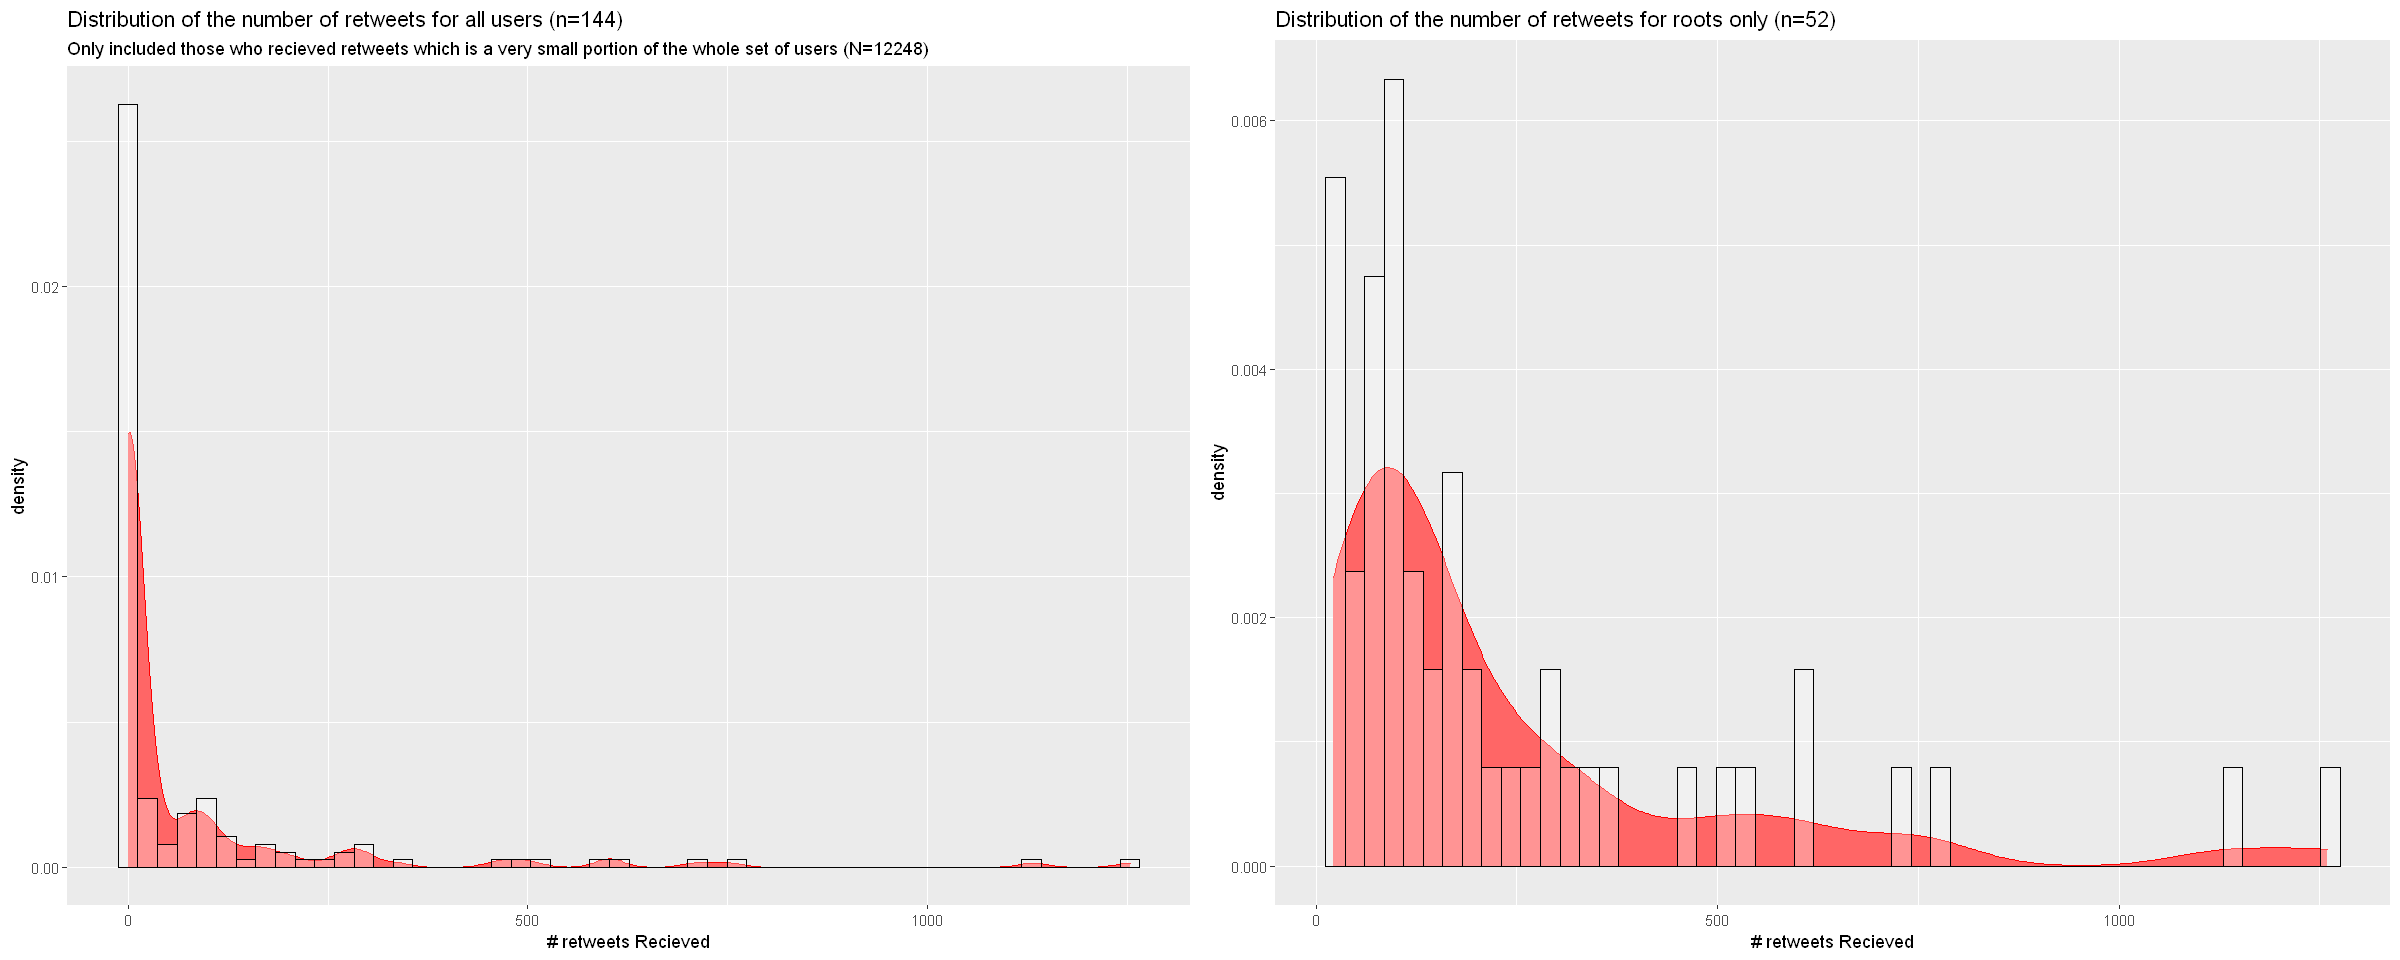

In [83]:
options(repr.plot.width=20, repr.plot.height=8)
q1 <- dataset %>% filter(retweets!=0) %>%
    ggplot(aes(x=retweets)) +
    geom_density(color='red',fill="#FF6666") +
    geom_histogram(aes(y=..density..),bins=52,alpha=.3, position="identity",colour="black", fill="white")+ 
    #coord_cartesian(ylim = c(0, .06), xlim=c(0,100)) + 
    labs(title = "Distribution of the number of retweets for all users (n=144)", x="# retweets Recieved",
         subtitle = "Only included those who recieved retweets which is a very small portion of the whole set of users (N=12248)")


q2 <- dataset %>%  filter(!is.na(response)) %>%
    ggplot(aes(x=response)) +
    geom_density(color='red',fill="#FF6666") +
    geom_histogram(aes(y=..density..),bins=52,alpha=.3, position="identity",colour="black", fill="white")+ 
    labs(title = "Distribution of the number of retweets for roots only (n=52)", x="# retweets Recieved")
 
#q2 <- ggplot() + geom_density(aes(x=rnorm(1000,0,1)), color='cyan',fill='cyan') 
#q3 <- ggplot() + geom_density(aes(x=rnorm(1000,1,1)), color='cyan',fill='cyan') 
#q4 <- ggplot() + geom_density(aes(x=rnorm(1000,2,1)), color='cyan',fill='cyan') 
#q5 <- ggplot() + geom_density(aes(x=rnorm(1000,2,2)), color='cyan',fill='cyan') 

grid.arrange(q1,q2,
  widths = c(1,1),
  layout_matrix = rbind(c(1, 2),
                        c(1, 2))
)

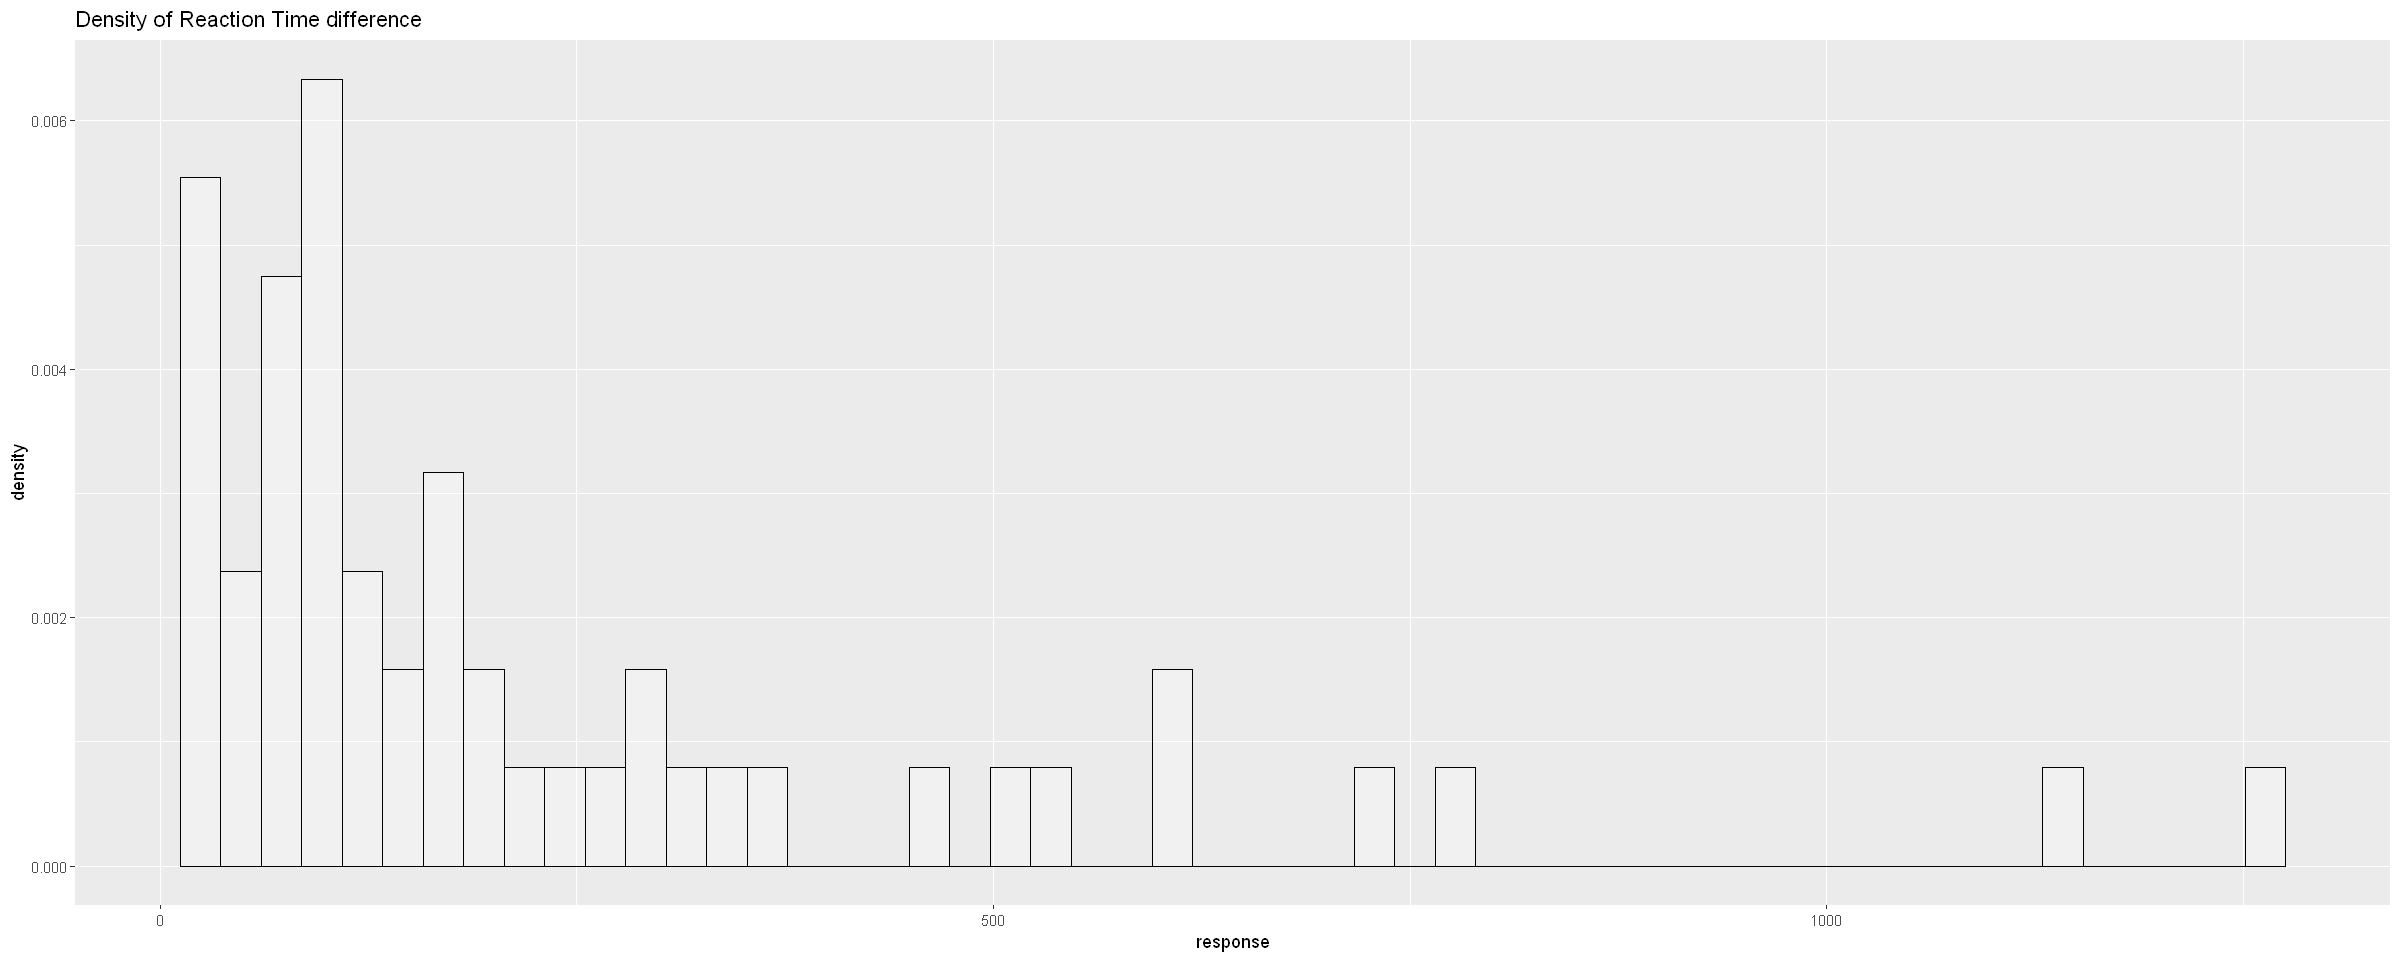

In [22]:
dataset %>% filter(!is.na(response))  %>%
    ggplot(aes(x=response)) +
    #geom_density(color='red',fill="#FF6666") +
    geom_histogram(aes(y=..density..),bins=52,alpha=.3, position="identity",colour="black", fill="white")+ 
    labs(title = "Density of Reaction Time difference")

In [82]:
sum((dataset$retweets!=0)+0)

[1] 155

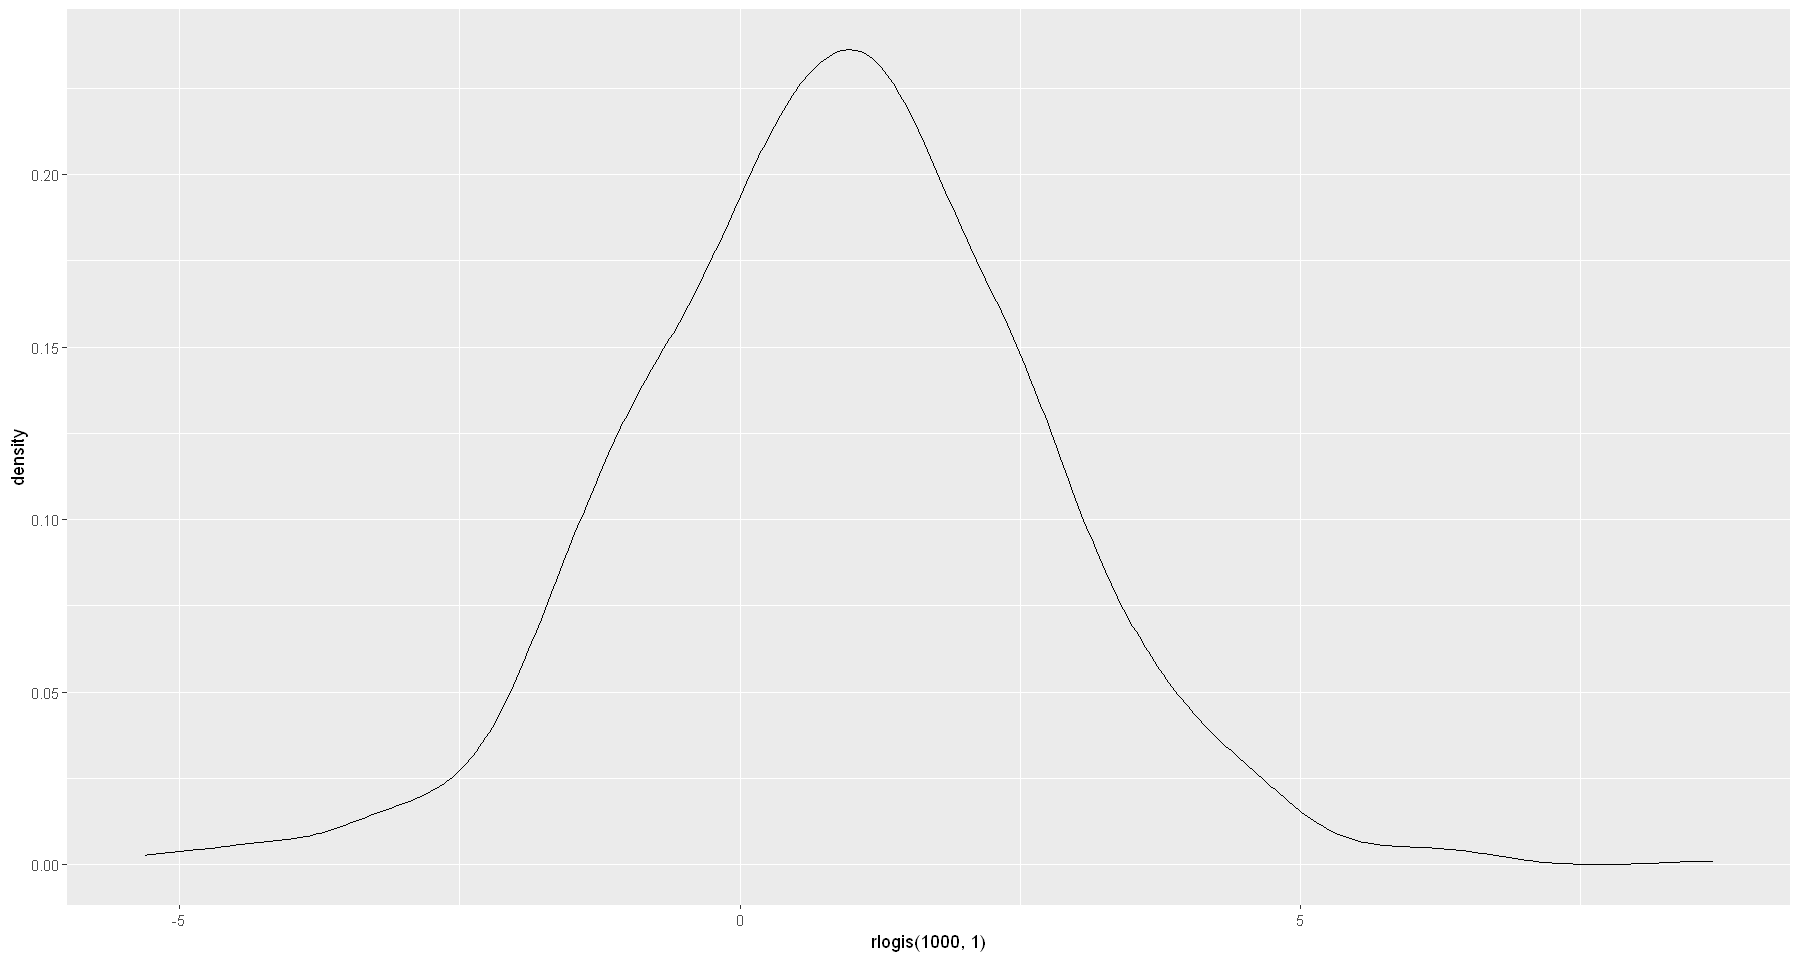

In [54]:
ggplot() + geom_density(aes(x=rlogis(1000,1)))